In [1]:
# Import Basics Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from nltk import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *

In [2]:
# Read in data from CSV
df = pd.read_csv('./IMBD/movie.csv')
df.columns =['Text', 'Sentiment']
df

,Text,Sentiment
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [3]:
# Downsample the data to ~6000 samples
percentage = 0.15
df_downsampled = df.sample(frac=percentage,random_state=0)
df_downsampled

,Text,Sentiment
12836,Wow. At first I thought who writes these thing...,1
10913,Not only is this a very interesting exploratio...,1
4214,Stewart is a Wyoming cattleman who dreams to m...,1
8198,Rachael Ray appeals to viewers of all ages and...,1
31403,I remembered this show from when i was a kid. ...,0
...,...,...
30130,I saw this film for the first time not too lon...,0
34016,"Wow...OK. So, after reading the little feud on...",0
12375,"This movie was fun, if all over the board.<br ...",1
16641,The movie is great and I like the story. I pre...,1


In [4]:
# Check for Null Values
if ( not df.isnull().values.any() ):
    print("Data set has no NULL values.")
else:
    null_tweets = df_downsampled[df_downsampled['Tweet'].isnull()].index.tolist()
    print("Null Tweets exist in Training Set. Dropping", len(null_tweets), "rows")
    df_downsampled.dropna(subset = ["Tweet"], inplace=True)
    print("Null values Exist In X,Y Training Set:", df_downsampled.isnull().values.any())

Data set has no NULL values.


In [5]:
# Train/Test Split
x = df_downsampled['Text']
y = df_downsampled['Sentiment']
TrainXdf,TestXdf, TrainYdf, TestYdf = train_test_split(x, y,test_size=.2, random_state=2)

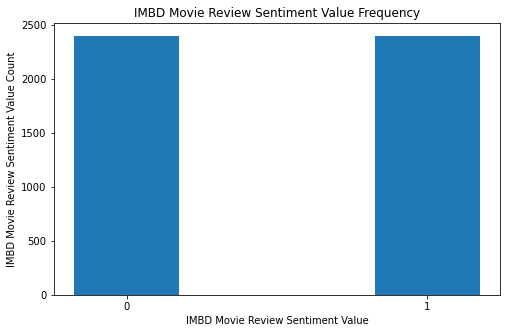

In [6]:
# Visual of Training Samples' Outcomes - Even Distribution of Outcomes
sent_count = TrainYdf.value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)

plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())
plt.xlabel('IMBD Movie Review Sentiment Value')
plt.ylabel('IMBD Movie Review Sentiment Value Count')
plt.title('IMBD Movie Review Sentiment Value Frequency')

plt.show()

In [7]:
# "One-Hot Encoding" Function that converts the Tweets to Numerical Arrays
def oneHotEnc(Tweet):
    token_item = []

    for letter in Tweet:
        if ord(letter) >= ord('a') and ord(letter) <= ord('z'):
            token_item.append(ord(letter) - ord('a'))
        elif letter == ' ':
            token_item.append(-1)
        else:
            pass

    return token_item

# Function that Pre-Processes the Tweets
def PreProcess(tweets):
    pre_procc_tweets = []

    for tweet in tweets:
        procc_tweet = oneHotEnc(tweet)
        pre_procc_tweets.append(procc_tweet)
        
    return pre_procc_tweets

# Encoding method (1 for NGRAM, 0 for TOKENIZATION)
method = 0

# Max Number of features for Tokenization
max_features = 700

# Pre-Process the Tweets and Get Finalized Training and Testing Sets
if (method ==1):
    TrainXdf = PreProcess(TrainXdf)
    TestXdf = PreProcess(TestXdf)

if (method ==0):
    cnt = CountVectorizer(analyzer="word", ngram_range=(1,1), max_features=max_features)
    TrainXdf = cnt.fit_transform(TrainXdf).toarray()
    TestXdf=cnt.transform(TestXdf).toarray()

TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)

print(TrainXdf.shape)
print(TestXdf.shape)

(4800, 700)
(1200, 700)


In [8]:
# Item Memory Generation Function, NGRAM
def itemMemGen_NGRAM(dim=10000, num_char=37):
    dictMem = np.random.randint(2, size=(num_char, dim), dtype='int32')
    return dictMem
# Item Memory Generation Function, TOKENIZATION
def itemMemGen_TOKEN(features, dim=10000):
    dictMem = np.random.randint(2, size=(features, dim), dtype='int32')
    return dictMem

# Hyperparamaters
HV_dim = 10000
num_supported_chars = 27

# Item Memory Generation
if (method ==1):
    itemMem = itemMemGen_NGRAM(dim=HV_dim, num_char=num_supported_chars)
else:
    itemMem = itemMemGen_TOKEN(features=len(TrainXdf[0]), dim=HV_dim)

In [9]:
# Function for Encoding a Tweet into a HV
def encode(tweet, itemMem, method, HV_dim=10000, n_gram_len=3):
    if (method==1):
        tweet_HV = np.zeros(HV_dim, dtype='int32')

        for ngram_start in range(0, len(tweet)-n_gram_len, 3):
            roll_value=n_gram_len
            for j in range(n_gram_len):
                letterHV = itemMem[tweet[ngram_start + j]]

                if (j==0):
                    product = letterHV
                elif (j==n_gram_len-1):
                    product = product * np.roll(letterHV, roll_value)
                    tweet_HV = np.add(tweet_HV, product)
                else:
                    product = product * np.roll(letterHV, roll_value)
                    
                roll_value = roll_value - 1

        HV_avg = np.average(tweet_HV)
        tweet_HV[tweet_HV > HV_avg] = 1
        tweet_HV[tweet_HV < HV_avg] = -1
        tweet_HV[tweet_HV == HV_avg] = 0
        return tweet_HV
    else:
        return tweet.dot(itemMem)

# HDC Training Function Creates Associative Memory
def train(X, Y, itemMem, HV_dim, sent_count, n_gram_len, method):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    encodedTweets=[]
    tweet_idx = 0
    
    for tweet in X:
        tweet_HV = encode(tweet.reshape(1, len(tweet)), itemMem, method, HV_dim, n_gram_len)
        if (tweet_idx==0):
            print(tweet_HV.shape)
        assocMem[Y[tweet_idx]] = np.add(assocMem[Y[tweet_idx]], tweet_HV)
        tweet_idx += 1

    return assocMem

n_gram_len = 3
assocMem = train(TrainXdf, TrainYdf, itemMem, HV_dim, len(sent_count), n_gram_len, method)
assocMem

(1, 10000)


array([[189583, 170011, 208952, ..., 189409, 209844, 199561],
       [189716, 164935, 204242, ..., 183770, 208822, 203827]])

In [10]:
# Function Compares Input HV to Class HVs and Returns the Predicted Class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

# Function Tests the Model and Return Accuracy of Model
def test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method):
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem, method, HV_dim, n_gram_len))
        if (TestYdf[index] == prediction):
            correct_count += 1
            
    accuracy = (correct_count / len(TestYdf)) * 100
    return accuracy

# One-Shot Training Results
one_shot_accuracy=test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method)
print("One Shot Accuracy: ", one_shot_accuracy)

One Shot Accuracy:  61.5


In [11]:
def retrain(X, Y, itemMem, assocMem, HV_dim, n_gram_len, method, alpha):
    tweet_index = 0
    print("start")
    for tweet in X:
        tweet_HV = encode(tweet, itemMem, method, HV_dim, n_gram_len)
        prediction = get_prediction(assocMem, tweet_HV)
        if prediction != Y[tweet_index]:
            assocMem[Y[tweet_index]] = np.add(assocMem[Y[tweet_index]], alpha * tweet_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * tweet_HV)
        tweet_index += 1
        if(tweet_index%10000 == 0):
            print("still going", tweet_index)
    return assocMem

# Re-Train Model
num_epochs = 20
print('-------- Retraining Model: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf ,itemMem, assocMem, HV_dim, n_gram_len, method, alpha = num_epochs - epoch)
    acc = test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method)
    print('Epoch ', (epoch+1), ': ', acc)

-------- Retraining Model:  20  Epochs --------
start
Epoch  1 :  75.5
start
Epoch  2 :  78.33333333333333
start
Epoch  3 :  75.91666666666667
start
Epoch  4 :  77.41666666666667
start
Epoch  5 :  78.83333333333333
start
Epoch  6 :  75.83333333333333
start
Epoch  7 :  77.41666666666667
start
Epoch  8 :  78.5
start
